In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [2]:
# Load your CSV
df = pd.read_csv("/home/elsherif/Desktop/Thesis/ViewPython/data/CleanupDataSet/final_model.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12479 entries, 0 to 12478
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         12479 non-null  object 
 1   total_rooftops               12479 non-null  int64  
 2   rooftops_without_solar       12479 non-null  int64  
 3   square_meters_with_solar_m2  12479 non-null  float64
 4   panel_area_m2                12479 non-null  float64
 5   district_number              12479 non-null  int64  
 6   year                         12479 non-null  int64  
 7   Unemployment_Rate            12479 non-null  float64
 8   Average_Age                  12479 non-null  float64
 9   Elderly_Population           12479 non-null  float64
 10  Young_Population             12479 non-null  float64
 11  Total_Population             12479 non-null  int64  
 12  tile_encoded                 12479 non-null  int64  
 13  panel_area_lag1 

In [4]:
df['panel_area_log'] = np.log1p(df['panel_area_m2'])


In [5]:
feature_cols = [
    'total_rooftops',
    # 'rooftops_without_solar',
    # 'square_meters_with_solar_m2',
    'Unemployment_Rate',
    'Average_Age',
    'Elderly_Population',
    'Young_Population',
    'Total_Population',
    'tile_encoded',
    'panel_area_lag1',
]

# Drop rows with missing lag values
df_model = df.dropna(subset=feature_cols + ['panel_area_log'])

X = df_model[feature_cols]
y = df_model['panel_area_log']


In [6]:
# Binary target: 1 if there is any solar, 0 if none
df_model['has_solar'] = (df_model['panel_area_log'] > 0).astype(int)


In [7]:
# Sort just to be safe
df_model = df_model.sort_values("year")

# Identify years
test_year = df_model["year"].max()
val_year  = df_model[df_model["year"] < test_year]["year"].max()

# Split data
train_df = df_model[df_model["year"] < val_year]
val_df   = df_model[df_model["year"] == val_year]
test_df  = df_model[df_model["year"] == test_year]

# Features and target
X_train_1 = train_df[feature_cols]
y_train_1 = train_df["has_solar"]

X_val_1 = val_df[feature_cols]
y_val_1 = val_df["has_solar"]

X_test_1 = test_df[feature_cols]
y_test_1 = test_df["has_solar"]


In [8]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score

# --------------------------------------------------
# Train LightGBM using TRAIN + VALIDATION
# --------------------------------------------------

clf = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=32,
    class_weight="balanced",
    random_state=42
)

clf.fit(
    X_train_1, y_train_1,
    eval_set=[(X_val_1, y_val_1)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# --------------------------------------------------
# Evaluate on TEST (never used during training)
# --------------------------------------------------

# Probability of solar adoption
p_solar_test = clf.predict_proba(X_test_1)[:, 1]

# Metrics
test_auc = roc_auc_score(y_test_1, p_solar_test)
test_acc = accuracy_score(y_test_1, clf.predict(X_test_1))

print(f"Stage 1 TEST ROC-AUC: {test_auc:.3f}")
print(f"Stage 1 TEST Accuracy: {test_acc:.3f}")

# --------------------------------------------------
# (Optional) Inspect best iteration
# --------------------------------------------------

print("Best number of trees:", clf.best_iteration_)


[LightGBM] [Info] Number of positive: 7662, number of negative: 1689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 9351, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.9899	valid_0's binary_logloss: 0.174014
Stage 1 TEST ROC-AUC: 0.991
Stage 1 TEST Accuracy: 0.910
Best number of trees: 190


In [9]:
# Probability of solar adoption
p_solar = clf.predict_proba(X_test_1)[:, 1]

# Optional: evaluate classifier
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc = roc_auc_score(y_test_1, p_solar)
acc = accuracy_score(y_test_1, clf.predict(X_test_1))

print(f"Stage 1 ROC-AUC: {roc_auc:.3f}, Accuracy: {acc:.3f}")


Stage 1 ROC-AUC: 0.991, Accuracy: 0.910


In [10]:
train_pos = train_df[train_df['has_solar'] == 1]
test_pos  = test_df  # keep all rows; we will multiply with p_solar later

X_train_2 = train_pos[feature_cols]
y_train_2 = train_pos['panel_area_log']  # target is log(area) to reduce skew
X_test_2  = test_df[feature_cols]


In [11]:
import xgboost as xgb

# Load your saved Stage 2 model
model_stage2 = xgb.XGBRegressor()
model_stage2.load_model("stage2_xgb.json")


In [46]:
# Predict log(panel_area) for all test tiles
y_pred_log = model_stage2.predict(X_test_2)

# Convert back to original scale (square meters)
import numpy as np
y_pred_size = np.expm1(y_pred_log)  # inverse of log1p


ValueError: feature_names mismatch: ['total_rooftops', 'rooftops_without_solar', 'square_meters_with_solar_m2', 'Unemployment_Rate', 'Average_Age', 'Elderly_Population', 'Young_Population', 'Total_Population', 'tile_encoded', 'panel_area_lag1', 'panel_area_lag2'] ['total_rooftops', 'Unemployment_Rate', 'Average_Age', 'Elderly_Population', 'Young_Population', 'Total_Population', 'tile_encoded', 'panel_area_lag1', 'panel_area_lag2']
expected square_meters_with_solar_m2, rooftops_without_solar in input data

In [24]:
y_pred_final = p_solar * y_pred_size

In [26]:
from sklearn.metrics import r2_score, mean_absolute_error

# Convert y_test back to original scale
y_test_real = np.expm1(test_df['panel_area_log'].values)

r2 = r2_score(y_test_real, y_pred_final)
mae = mean_absolute_error(y_test_real, y_pred_final)

print(f"2-Stage Model R²: {r2:.3f}, MAE: {mae:.3f}")


2-Stage Model R²: 0.734, MAE: 186.390


In [27]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(test_df['has_solar'], p_solar)
print(f"Stage 1 ROC-AUC: {roc_auc:.3f}")


Stage 1 ROC-AUC: 0.999


In [30]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 12.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:0000:0100:01


Analysis

In [31]:
import shap
import numpy as np


In [36]:
import shap

explainer = shap.TreeExplainer(clf)

X_shap = X_test_1.sample(1000, random_state=42)

shap_values = explainer(X_shap)


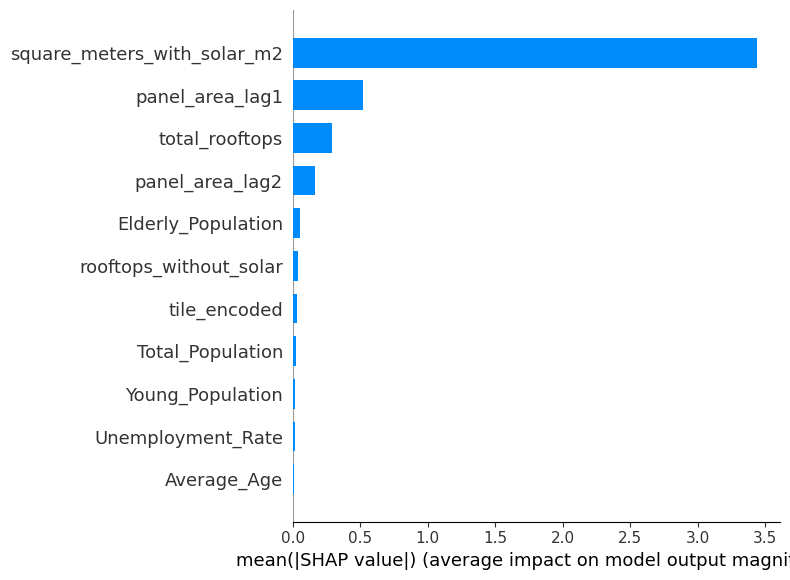

In [37]:
shap.summary_plot(
    shap_values.values,
    X_shap,
    plot_type="bar"
)
